In [6]:
setwd("~/R/Rdata")

In [1]:
library(data.table)

In [7]:
#loading datasets
#links <- read.csv("links.csv")
movies <- read.csv("workshop_movies.csv",stringsAsFactors=FALSE)
ratings <- read.csv("workshop_ratings.csv")
#tags <- read.csv("tags.csv")

In [13]:
#install.packages("recommenderlab")
library(recommenderlab)
library(ggplot2)

Loading required package: Matrix
Loading required package: arules

Attaching package: ‘arules’

The following objects are masked from ‘package:base’:

    abbreviate, write

Loading required package: proxy

Attaching package: ‘proxy’

The following object is masked from ‘package:Matrix’:

    as.matrix

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix

Loading required package: registry


In [12]:
## Data pre-processing
genres <- as.data.frame(movies$genres, stringsAsFactors=FALSE)

In [13]:
head(genres)

movies$genres
Adventure|Animation|Children|Comedy|Fantasy
Adventure|Children|Fantasy
Comedy|Romance
Comedy|Drama|Romance
Comedy
Action|Crime|Thriller


In [14]:
library(tidyr)


Attaching package: ‘tidyr’

The following object is masked from ‘package:Matrix’:

    expand



In [2]:
library(reshape2)


Attaching package: ‘reshape2’

The following objects are masked from ‘package:data.table’:

    dcast, melt



In [8]:
#Create ratings matrix. Rows = userId, Columns = movieId
ratingmat <- dcast(ratings, userId~movieId, value.var = "rating", na.rm=FALSE)
ratingmat <- as.matrix(ratingmat[,-1]) #remove userIds

In [14]:

# Method: UBCF
# Similarity Calculation Method: Cosine Similarity
# Nearest Neighbors: 30
#Convert rating matrix into a recommenderlab sparse matrix
ratingmat <- as(ratingmat, "realRatingMatrix")

In [15]:
# Determine how similar the first four users are with each other
# create similarity matrix
similarity_users <- similarity(ratingmat[1:4, ], 
                               method = "cosine", 
                               which = "users")

In [16]:
as.matrix(similarity_users)

,1,2,3,4
1,0.0000000,NA,NA,0.9085757
2,NA,0.0000000,0.9556143,0.9627467
3,NA,0.9556143,0.0000000,0.9752314
4,0.9085757,0.9627467,0.9752314,0.0000000


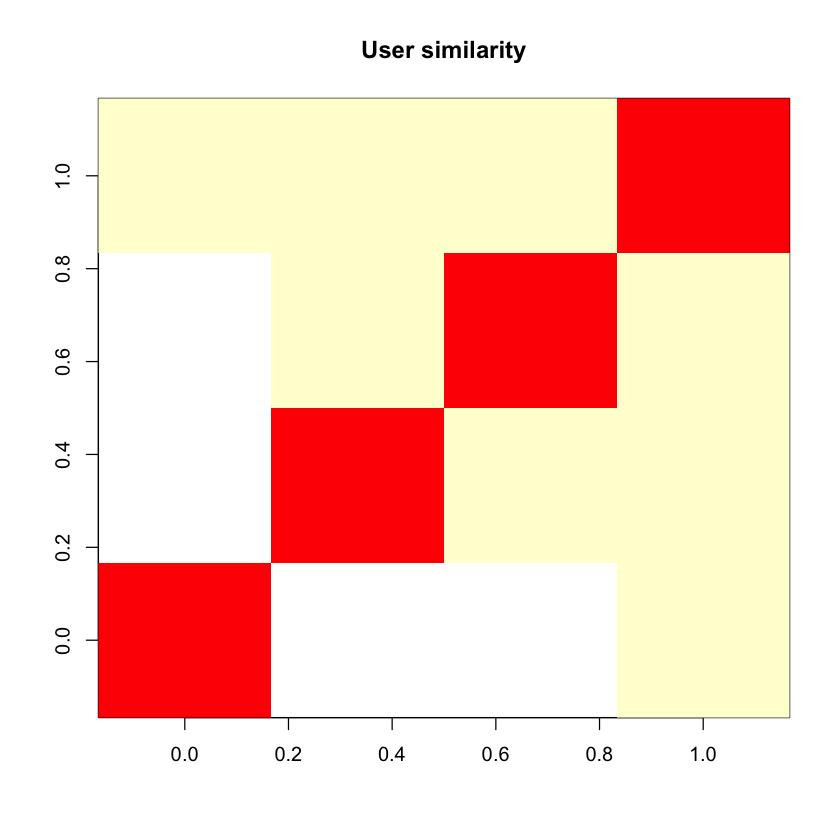

In [18]:
library(ggplot2)
#In the given matrix, each row and each column corresponds to a user, and each cell corresponds to the similarity between two users. 
image(as.matrix(similarity_users), main = "User similarity")

,1,2,3,4
1,0.0000000,0.9633071,0.9269097,0.9321358
2,0.9633071,0.0000000,0.9514238,0.9478533
3,0.9269097,0.9514238,0.0000000,0.9396185
4,0.9321358,0.9478533,0.9396185,0.0000000


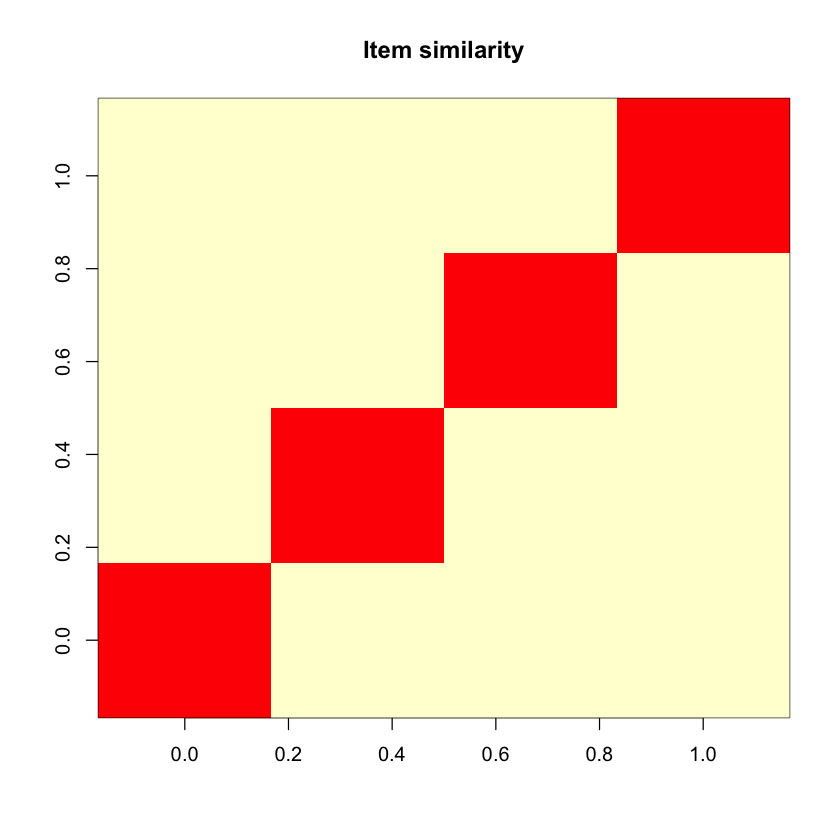

In [19]:

# compute similarity between
# the first four movies
similarity_items <- similarity(ratingmat[, 1:4], method =
                                 "cosine", which = "items")
as.matrix(similarity_items)
image(as.matrix(similarity_items), main = "Item similarity")

### Further data exploration 

In [20]:
# Exploring values of ratings:
vector_ratings <- as.vector(ratingmat@data)
unique(vector_ratings) # what are unique values of ratings

[1] 0.0 3.0 4.0 5.0 2.0 3.5 1.0 2.5 4.5 1.5 0.5

In [21]:
table_ratings <- table(vector_ratings) # what is the count of each rating value
table_ratings


vector_ratings
      0     0.5       1     1.5       2     2.5       3     3.5       4     4.5 
5983282    1101    3326    1687    7271    4449   20064   10538   28750    7723 
      5 
  15095 

In [22]:
# Visualize the rating:
vector_ratings <- vector_ratings[vector_ratings != 0] # rating == 0 are NA values
vector_ratings <- factor(vector_ratings)

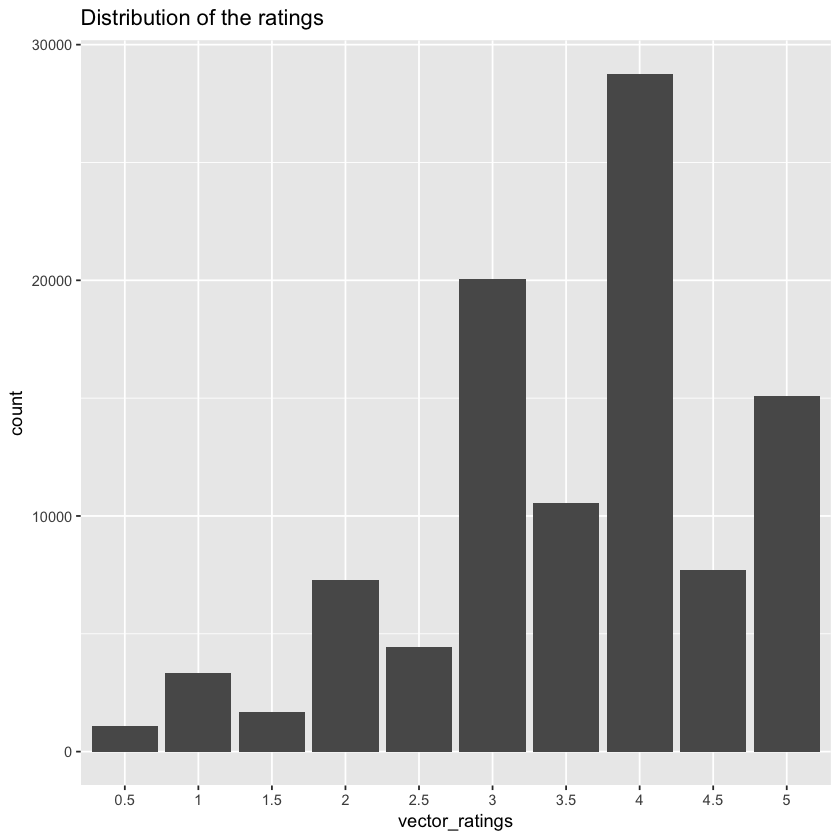

In [23]:
qplot(vector_ratings) + 
  ggtitle("Distribution of the ratings") #less low (less than 3) rating scores, the majority of movies are rated with a score of 3 or higher. The most common rating is 4


In [26]:
# Exploring viewings of movies:
views_per_movie <- colCounts(ratingmat) # count views for each movie
head(views_per_movie)

1   2   3   4   5   6 
247 107  59  13  56 104

In [27]:
table_views <- data.frame(movie = names(views_per_movie),
                          views = views_per_movie) # create dataframe of views
table_views <- table_views[order(table_views$views, 
                                 decreasing = TRUE), ] # sort by number of views

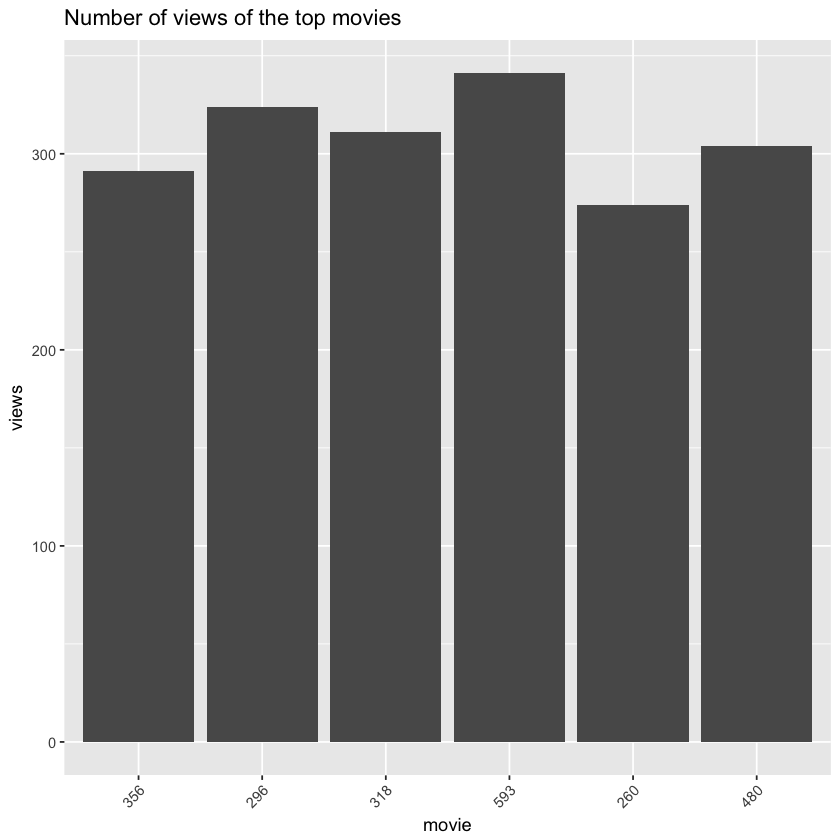

In [31]:
#let’s see what are the most viewed movies.
ggplot(table_views[1:6, ], aes(x = movie, y = views)) +
  geom_bar(stat="identity") + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
  scale_x_discrete(labels=subset(movies2, movies2$movieId == table_views$movie)$title) +
  ggtitle("Number of views of the top movies")

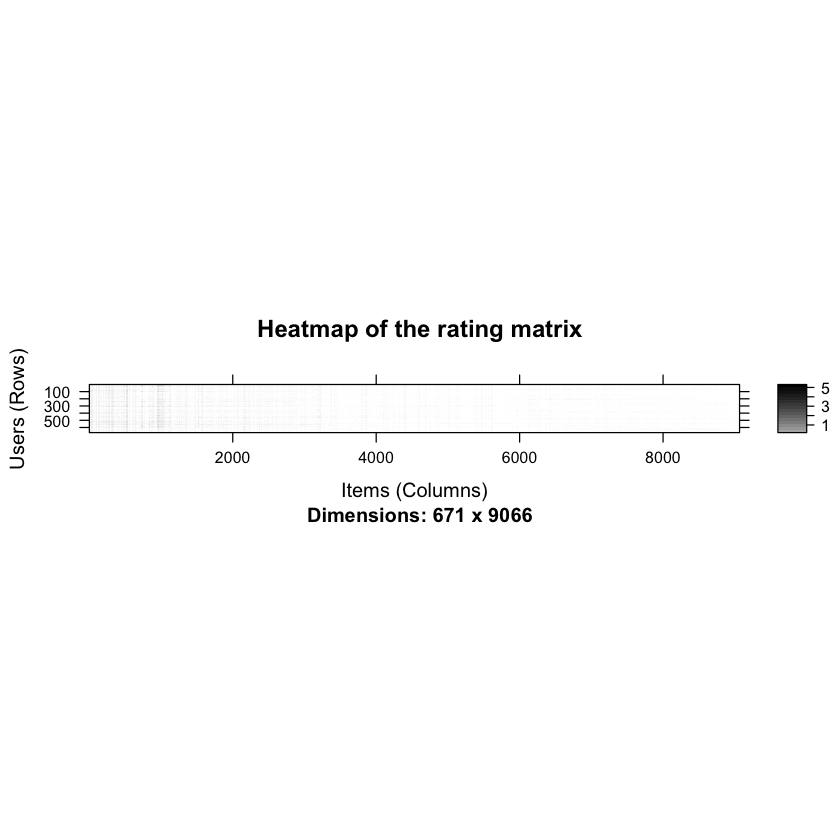

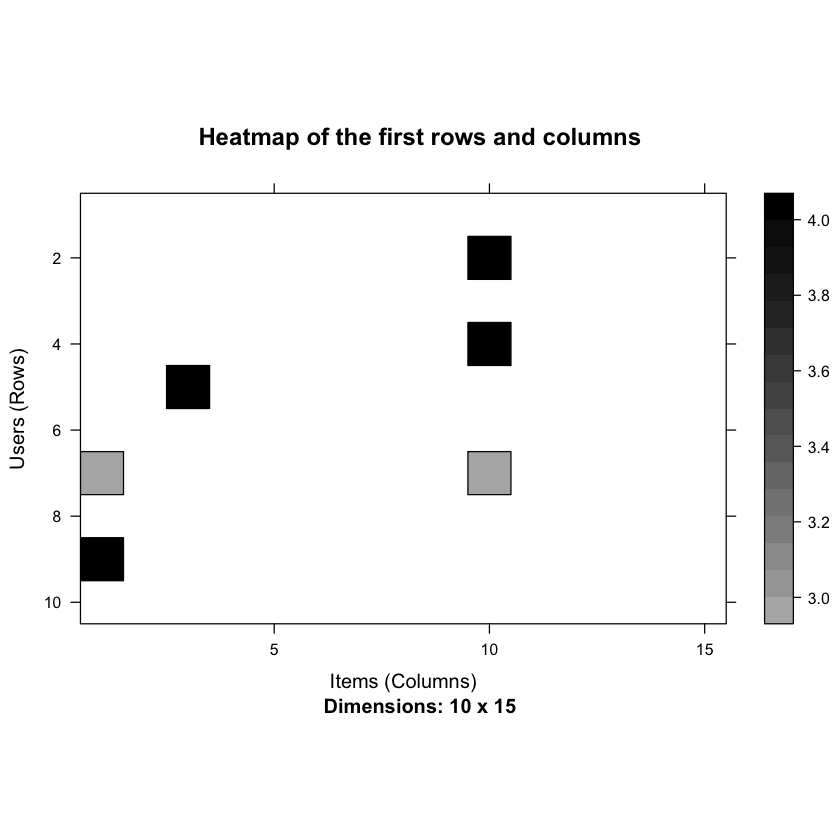

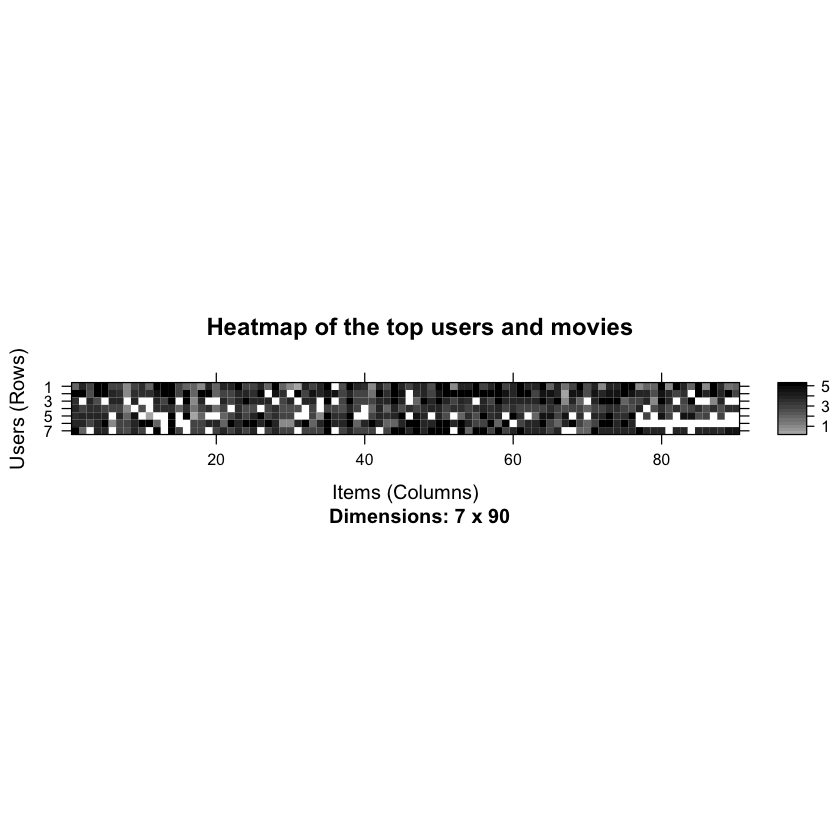

In [32]:
#Visualizing the matrix:Heatmap of the rating matrix
#visualize the whole matrix of ratings by building a heat map whose colors represent the ratings. Each row of the matrix corresponds to a user, each column to a movie, and each cell to its rating.
image(ratingmat, main = "Heatmap of the rating matrix") # hard to read-too many dimensions
image(ratingmat[1:10, 1:15], main = "Heatmap of the first rows and columns")
image(ratingmat[rowCounts(ratingmat) > quantile(rowCounts(ratingmat), 0.99),
                 colCounts(ratingmat) > quantile(colCounts(ratingmat), 0.99)], 
      main = "Heatmap of the top users and movies")

In [33]:
#Some users saw more movies than the others. 
#So, instead of displaying some random users and items, I should select the most relevant users and items. Thus I visualize only the users who have seen many movies and the movies that have been seen by many users. 
#To identify and select the most relevant users and movies, I follow these steps:
#Determine the minimum number of movies per user.
#Determine the minimum number of users per movie.
#Select the users and movies matching these criteria.

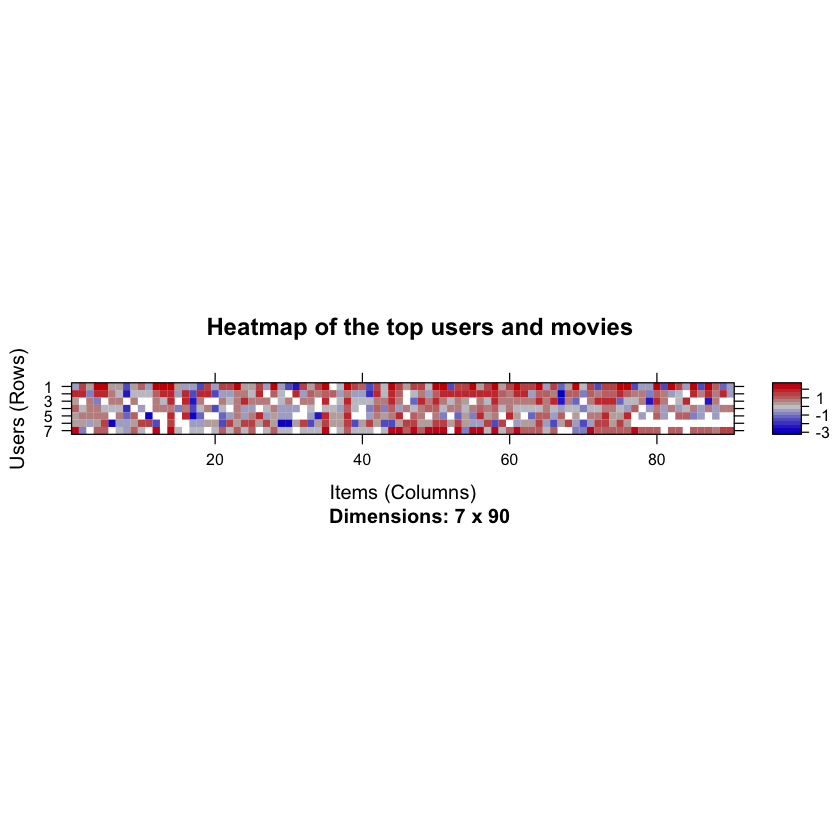

In [34]:
#Normalize the data
ratingmat_norm <- normalize(ratingmat)
image(ratingmat_norm[rowCounts(ratingmat_norm) > quantile(rowCounts(ratingmat_norm), 0.99),
                colCounts(ratingmat_norm) > quantile(colCounts(ratingmat_norm), 0.99)], 
      main = "Heatmap of the top users and movies")